# FORECASTING FOR AR LINEAR MODEL

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
temp_data_train = pd.read_csv('../../Data/train_data.csv')
temp_data_test  = pd.read_csv('../../Data/test_data.csv')

# Convert the 'date' column to datetime
temp_data_train['date'] = pd.to_datetime(temp_data_train['date'])
temp_data_test['date']  = pd.to_datetime(temp_data_test['date'])

temp_data_train['average_temperature']  = (temp_data_train['min']+temp_data_train['max'])/2
temp_data_test['average_temperature']   = (temp_data_test['min']+temp_data_test['max'])/2

T_actual_train  = temp_data_train['average_temperature'].to_numpy()
T_actual_test   = temp_data_test['average_temperature'].to_numpy()

temp_data_test.head()

,date,mean,max,min,average_temperature
0,2024-04-01,10.33,20.39,3.61,12.000
1,2024-04-02,13.22,24.22,4.50,14.360
2,2024-04-03,14.72,24.39,3.72,14.055
3,2024-04-04,12.28,24.22,5.11,14.665
4,2024-04-05,8.22,16.89,3.50,10.195


Linear and Seasonal forecast

In [3]:
import json

with open("linear_trend_params.json", "r") as f:
    trend_values_dict = json.load(f)

# Forecast horizon
forecast_end = 365

# Match test set for later
T_actual_test = T_actual_test[:forecast_end]

# Create empty DataFrame with placeholders
forecast_df = pd.DataFrame(index=np.arange(forecast_end), columns=['date', 't', 'trend', 'seasonal', 'forecast', 'actual'])

# Assign actual values (truncate if necessary)
forecast_df['actual'] = T_actual_test[:forecast_end]

# Set date range starting from first test date
start_date          = temp_data_test['date'].iloc[0]
date_range          = pd.date_range(start=start_date, periods=forecast_end)
forecast_df['date'] = date_range

# Set time index t continuing from training period
start_t          = len(temp_data_train[temp_data_train['date'] >= '2003-01-01'])  #NOTE: this must be consistent with the last run in main
forecast_df['t'] = np.arange(start_t + 1, start_t + forecast_end + 1)

#Access the trend parameters
slope     = trend_values_dict["slope"]
intercept = trend_values_dict["intercept"]


# Calculate the trend using the linear equation
forecast_df['trend'] = intercept + slope*forecast_df['t']

# View the first few rows
print(forecast_df.head())

        date     t      trend seasonal forecast  actual
0 2024-04-01  7755  17.556618      NaN      NaN  12.000
1 2024-04-02  7756  17.556535      NaN      NaN  14.360
2 2024-04-03  7757  17.556452      NaN      NaN  14.055
3 2024-04-04  7758  17.556370      NaN      NaN  14.665
4 2024-04-05  7759  17.556287      NaN      NaN  10.195


In [4]:
import numpy as np
import json

# Load fitted parameters
with open("seasonal_mean_params.json", "r") as f:
    fitted_params = json.load(f)

# Define the same periods used in the fitting notebook
periods = [365, 730, 1460, 2920, 5840, 11680]
num_components = len(periods)

def forecast_seasonal(t, fitted_params):
    """
    Forecast seasonal component using fitted sinusoidal model.
    
    Parameters:
    t: array-like, time values to forecast on (e.g., future days)
    fitted_params: list, fitted parameters [C, a1, phi1, a2, phi2, ..., aN, phiN]
    
    Returns:
    array of forecasted seasonal values
    """
    C = fitted_params[0]
    seasonal_sum = np.zeros_like(t, dtype=float)
    
    for i in range(num_components):
        a_i = fitted_params[1 + 2 * i]
        phi_i = fitted_params[2 + 2 * i]
        p_i = periods[i]
        seasonal_sum += a_i * np.sin(2 * np.pi * (t - phi_i) / p_i)
    
    return C + seasonal_sum

# Forecasting for future time steps
t_future = np.arange(start_t + 1, start_t + forecast_end + 1)

# Generate forecast
seasonal_forecast = forecast_seasonal(t_future, fitted_params)

# Add seasonal forecast to the forecast dataframe
forecast_df['seasonal'] = seasonal_forecast[:forecast_end]

In [5]:
forecast_df['residual'] = forecast_df['actual'] - (forecast_df['trend'] + forecast_df['seasonal'])
print(forecast_df.head())

        date     t      trend  seasonal forecast  actual  residual
0 2024-04-01  7755  17.556618 -3.220409      NaN  12.000 -2.336209
1 2024-04-02  7756  17.556535 -3.103734      NaN  14.360 -0.092801
2 2024-04-03  7757  17.556452 -2.986047      NaN  14.055 -0.515405
3 2024-04-04  7758  17.556370 -2.867381      NaN  14.665 -0.023988
4 2024-04-05  7759  17.556287 -2.747772      NaN  10.195 -4.613515


In [6]:
with open("variance_params.json", "r") as f:
    variance_params = json.load(f)

def forecast_sigmaboy(t_future, fitted_params):
    """
    Forecast seasonal variance using fitted sinusoidal model
    
    Parameters:
    t_future: array-like, future time points to forecast
    fitted_params: list or array containing [a1, phi1, a2, phi2, a3, phi3, a4, phi4]
    
    Returns:
    array of forecasted seasonal values
    """
    c0, a1, b1, a2, b2, a3, b3, a4, b4 = fitted_params
    
    # Calculate each component
    return (c0 + a1 * np.cos(2 * np.pi * 1 * t_future / 365) + b1 * np.sin(2 * np.pi * 1 * t_future / 365) +
          a2 * np.cos(2 * np.pi * 2 * t_future / 365) + b2 * np.sin(2 * np.pi * 2 * t_future / 365) +
          a3 * np.cos(2 * np.pi * 3 * t_future / 365) + b3 * np.sin(2 * np.pi * 3 * t_future / 365) +
          a4 * np.cos(2 * np.pi * 4 * t_future / 365) + b4 * np.sin(2 * np.pi * 4 * t_future / 365))

figa = forecast_df['date'].iloc[0].dayofyear
t_future = np.arange(figa, figa + forecast_end + 1)

# Your fitted parameters from the model
fitted_params = variance_params

# Generate forecast
sigmaboy_sq = forecast_sigmaboy(t_future, fitted_params)

sigmaboy = np.sqrt(sigmaboy_sq)

# Add volatility forecast to the forecast dataframe
forecast_df['sigmaboy'] = sigmaboy[:forecast_end]

forecast_df['sigmaboy']


0      1.835852
1      1.837163
2      1.838408
3      1.839581
4      1.840672
         ...   
360    1.828614
361    1.830124
362    1.831612
363    1.833068
364    1.834484
Name: sigmaboy, Length: 365, dtype: float64

In [7]:
print(forecast_df.head())

        date     t      trend  seasonal forecast  actual  residual  sigmaboy
0 2024-04-01  7755  17.556618 -3.220409      NaN  12.000 -2.336209  1.835852
1 2024-04-02  7756  17.556535 -3.103734      NaN  14.360 -0.092801  1.837163
2 2024-04-03  7757  17.556452 -2.986047      NaN  14.055 -0.515405  1.838408
3 2024-04-04  7758  17.556370 -2.867381      NaN  14.665 -0.023988  1.839581
4 2024-04-05  7759  17.556287 -2.747772      NaN  10.195 -4.613515  1.840672


Random shocks (eps) for path 1: [ 0.3388638   0.03469685 -1.49110166  0.27002912 -0.16663599  1.19350072
  1.51011038  0.06024188 -0.03634806 -0.69656575  0.18770058 -0.21391936
  0.8410074  -1.38401772 -1.52906576 -1.24979621  0.03492957 -0.32279906
 -0.53097066  0.42874718  1.16991739 -2.17686826  0.86302574  0.89305189
 -0.50426784  0.19407972  2.01745052  1.66484426  0.18702435  1.16071708
 -1.71931966  0.24328219  1.93470755 -0.63028184  0.97775156  1.85591672
  0.01630072  1.09588226 -1.22221842  1.07129547 -0.11892399  1.25334504
  0.64161916 -1.36217626 -0.34121647 -1.78065569  1.33988636  0.53513909
 -1.8084258   0.22474807 -0.75474025 -0.69951581  0.86934149 -0.5673485
 -0.65406592  0.23402719 -1.04180266 -0.03473551 -1.00474742  0.79064892
 -0.9891512   0.05535096  0.20927971 -0.12819552  1.78430166  0.59959794
  1.20592187  0.94133878  0.59660511  1.30702809 -0.73796983  0.84216718
 -1.39107454 -1.06232124 -0.03185604 -1.63571211  0.45039278  1.25537657
 -0.47106612 -0.6195

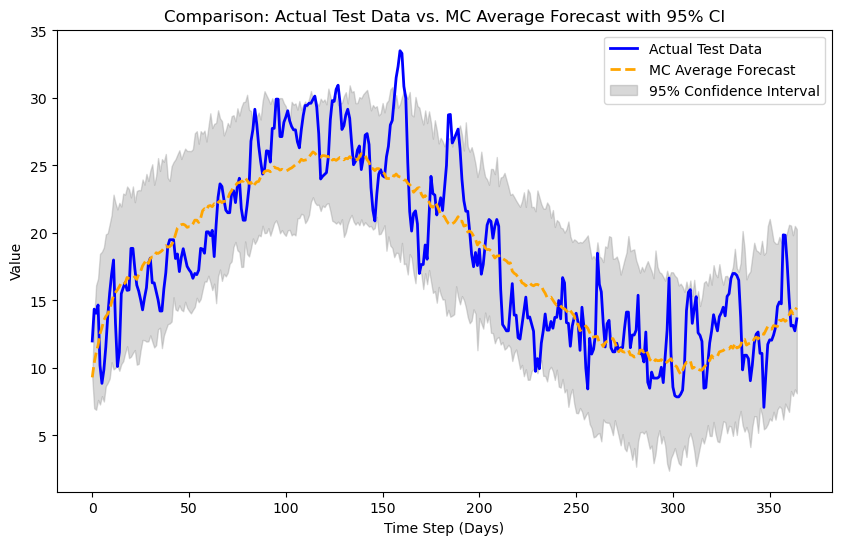

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Existing Monte Carlo simulation code ---
k       = -0.1668                  #NOTE: This must be matched with the last run in main
n_paths = 100                      # Number of Monte Carlo simulation paths

# Assume forecast_end, T_actual_train, T_actual_test, and forecast_df are defined elsewhere
# For example, T_actual_train and T_actual_test could be numpy arrays, and forecast_df a DataFrame

# Initialize forecasts: start with the last actual observation from training data.
T_all = np.zeros((n_paths, forecast_end))
T_all[:, 0] = T_actual_train[-1]

# Rolling forecast using actual data when available
for t in range(1, forecast_end):
    eps = np.random.randn(n_paths)  # random shock for each simulation path
    # Debugging prints (optional)
    print(f"Random shocks (eps) for path {t}: {eps}")
    
    previous_value = T_all[:, t-1]
    T_all[:, t] = (previous_value  
                   + forecast_df['trend'].iloc[t] - forecast_df['trend'].iloc[t-1] 
                   + forecast_df['seasonal'].iloc[t] - forecast_df['seasonal'].iloc[t-1]  
                   + k * (previous_value - forecast_df['seasonal'].iloc[t-1] - forecast_df['trend'].iloc[t-1]) 
                   + forecast_df['sigmaboy'].iloc[t-1]*eps
    )
    
    # Additional debugging prints (optional)
    print(f"Path {t}: Previous Value: {previous_value}, Forecast: {T_all[:, t]}")
    print(f"Forecast for time step {t}: {forecast_df['sigmaboy'].iloc[t]}")
    print(f"Forecast for time step {t}: {forecast_df['trend'].iloc[t] - forecast_df['trend'].iloc[t-1]}")
    print(f"Forecast for time step {t}: {forecast_df['seasonal'].iloc[t] - forecast_df['seasonal'].iloc[t-1]}")
    print(f"Forecast for time step {t}: {k * (previous_value - forecast_df['seasonal'].iloc[t-1] - forecast_df['trend'].iloc[t-1])}")
    print(f"Forecast for time step {t}: {forecast_df['trend'].iloc[t-1]*eps}")
    print(f"Forecast for time step {t}: {forecast_df['seasonal'].iloc[t]*eps}")

# Calculate the average forecast over all simulation paths.
T_avg = np.mean(T_all, axis=0)

# --- Compute error statistics between T_avg and T_actual_test ---
mae = mean_absolute_error(T_actual_test, T_avg)
mse = mean_squared_error(T_actual_test, T_avg)
rmse = np.sqrt(mse)
corr_coef = np.corrcoef(T_actual_test, T_avg)[0, 1]

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Correlation Coefficient:", corr_coef)

# --- Plot the Actual Test Data vs. MC Average Forecast with Confidence Interval ---
# Compute confidence interval bounds from the Monte Carlo simulation:
# For a 95% confidence interval, get the 2.5th and 97.5th percentiles.
lower_ci = np.percentile(T_all, 2.5, axis=0)
upper_ci = np.percentile(T_all, 97.5, axis=0)

plt.figure(figsize=(10, 6))

# Assuming T_actual_test and T_avg have the same length as forecast_end.
time_steps = np.arange(forecast_end)  # or adjust as needed

# Plot actual test data and average forecast
plt.plot(time_steps, T_actual_test, label="Actual Test Data", linewidth=2, color='blue')
plt.plot(time_steps, T_avg, label="MC Average Forecast", linewidth=2, linestyle="--", color='orange')

# Add the confidence interval as a shaded area.
plt.fill_between(time_steps, lower_ci, upper_ci, color='gray', alpha=0.3, label='95% Confidence Interval')

plt.xlabel("Time Step (Days)")
plt.ylabel("Value")
plt.title("Comparison: Actual Test Data vs. MC Average Forecast with 95% CI")
plt.legend()
plt.show()

In [9]:
print(np.isnan(T_actual_test).sum())  # Number of NaNs in T_actual_test
print(np.isnan(T_avg).sum())          # Number of NaNs in T_avg

0
0


Mean Absolute Error (MAE): 1.185053443865535
Mean Squared Error (MSE): 2.425648037504168
Root Mean Squared Error (RMSE): 1.557449208643469
Correlation Coefficient: 0.9703546416158817


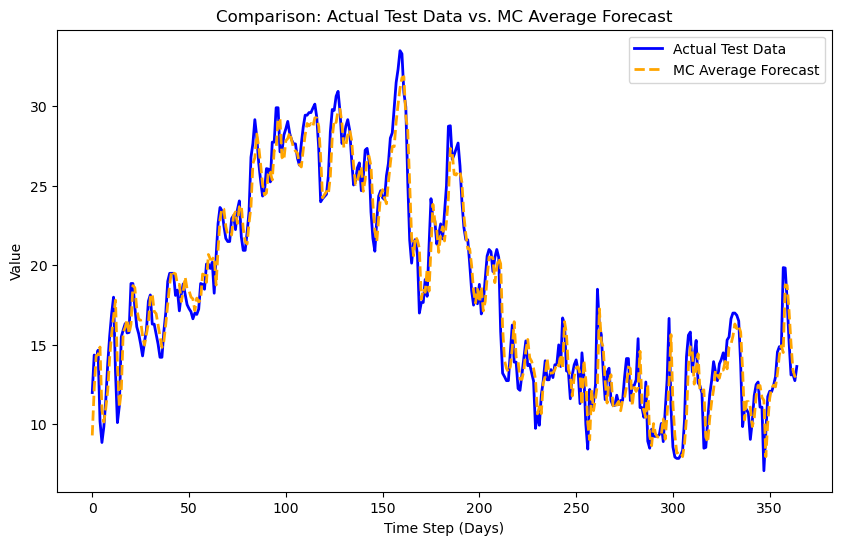

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

k       = -0.1740                  #NOTE: This must be matched with the last run in main
n_paths = 100                      # Number of Monte Carlo simulation paths

# Initialize forecasts: start with the last actual observation from training data.
T_all = np.zeros((n_paths, forecast_end))
T_all[:, 0] = T_actual_train[-1]

# Rolling forecast using actual data when available
for t in range(1, forecast_end):
    eps = np.random.randn(n_paths)  # random shock for each simulation path
    
    # Use the actual observed data at t-1 if available, otherwise fall back on the simulation
    if t-1 < len(T_actual_test):
        previous_value = T_actual_test[t-1]
    else:
        # If actual data is not available (e.g., beyond the test sample), you may use the forecasted average:
        previous_value = np.mean(T_all[:, t-1])
    
    # Compute the forecast for time t based on the actual observation at t-1.
    T_all[:, t] = (previous_value  
                   + forecast_df['trend'].iloc[t] - forecast_df['trend'].iloc[t-1] 
                   + forecast_df['seasonal'].iloc[t] - forecast_df['seasonal'].iloc[t-1]  
                   + k * (previous_value - forecast_df['seasonal'].iloc[t-1] - forecast_df['trend'].iloc[t-1]) 
                   + forecast_df['sigmaboy'].iloc[t-1]*eps
    )

# Calculate the average forecast over all simulation paths.
T_avg = np.mean(T_all, axis=0)

# -- Compute error statistics between T_avg and T_actual_test --
mae = mean_absolute_error(T_actual_test, T_avg)
mse = mean_squared_error(T_actual_test, T_avg)
rmse = np.sqrt(mse)
corr_coef = np.corrcoef(T_actual_test, T_avg)[0, 1]

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Correlation Coefficient:", corr_coef)

# -- Plot the Actual Test Data vs. MC Average Forecast --
plt.figure(figsize=(10, 6))
plt.plot(T_actual_test, label="Actual Test Data", linewidth=2, color='blue')
plt.plot(T_avg, label="MC Average Forecast", linewidth=2, linestyle="--", color='orange')
plt.xlabel("Time Step (Days)")
plt.ylabel("Value")
plt.title("Comparison: Actual Test Data vs. MC Average Forecast")
plt.legend()
plt.show()